In [1]:
# -----------
# User Instructions
#
# Implement a P controller by running 100 iterations
# of robot motion. The desired trajectory for the 
# robot is the x-axis. The steering angle should be set
# by the parameter tau so that:
#
# steering = -tau * crosstrack_error
#
# You'll only need to modify the `run` function at the bottom.
# ------------
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Robot(object):
    def __init__(self, length=20.0):
        """
        Creates robot and initializes location/orientation to 0, 0, 0.
        """
        self.x = 0.0
        self.y = 0.0
        self.orientation = 0.0
        self.length = length
        self.steering_noise = 0.0
        self.distance_noise = 0.0
        self.steering_drift = 0.0

    def set(self, x, y, orientation):
        """
        Sets a robot coordinate.
        """
        self.x = x
        self.y = y
        self.orientation = orientation % (2.0 * np.pi)

    def set_noise(self, steering_noise, distance_noise):
        """
        Sets the noise parameters.
        """
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.steering_noise = steering_noise
        self.distance_noise = distance_noise

    def set_steering_drift(self, drift):
        """
        Sets the systematical steering drift parameter
        """
        self.steering_drift = drift

    def move(self, steering, distance, tolerance=0.001, max_steering_angle=np.pi / 4.0):
        """
        steering = front wheel steering angle, limited by max_steering_angle
        distance = total distance driven, most be non-negative
        """
        if steering > max_steering_angle:
            steering = max_steering_angle
        if steering < -max_steering_angle:
            steering = -max_steering_angle
        if distance < 0.0:
            distance = 0.0

        # apply noise
        steering2 = random.gauss(steering, self.steering_noise)
        distance2 = random.gauss(distance, self.distance_noise)

        # apply steering drift
        steering2 += self.steering_drift

        # Execute motion
        turn = np.tan(steering2) * distance2 / self.length

        if abs(turn) < tolerance:
            # approximate by straight line motion
            self.x += distance2 * np.cos(self.orientation)
            self.y += distance2 * np.sin(self.orientation)
            self.orientation = (self.orientation + turn) % (2.0 * np.pi)
        else:
            # approximate bicycle model for motion
            radius = distance2 / turn
            cx = self.x - (np.sin(self.orientation) * radius)
            cy = self.y + (np.cos(self.orientation) * radius)
            self.orientation = (self.orientation + turn) % (2.0 * np.pi)
            self.x = cx + (np.sin(self.orientation) * radius)
            self.y = cy - (np.cos(self.orientation) * radius)

    def __repr__(self):
        return '[x=%.5f y=%.5f orient=%.5f]' % (self.x, self.y, self.orientation)

In [3]:
############## ADD / MODIFY CODE BELOW ####################
# ------------------------------------------------------------------------
# run - does a single control run
robot = Robot()
robot.set(0, 1, 0)

# below is my try,
# def run(robot, tau, n=100, speed=1.0):
#     x_trajectory = []
#     y_trajectory = []
#     x_trajectory.append(robot.x)
#     y_trajectory.append(robot.y)
#     for i in range(1, n):
#         robot.x = robot.x + speed * np.cos(tau)
#         x_trajectory.append(robot.x);
#         if robot.y > 0:
#             robot.y = robot.y - speed * np.sin(tau)
#         else:
#             robot.y = robot.y + speed * np.sin(tau)
#         y_trajectory.append(robot.y)     
#     # TODO: your code here
#     return x_trajectory, y_trajectory
    
# below is the teacher's try:
def run_P(robot, tau, n=100, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    # TODO: your code here
    for i in range(n):
        cross_track_error = robot.y
        steer = -tau * cross_track_error
        robot.move(steer, speed)
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
    return x_trajectory, y_trajectory

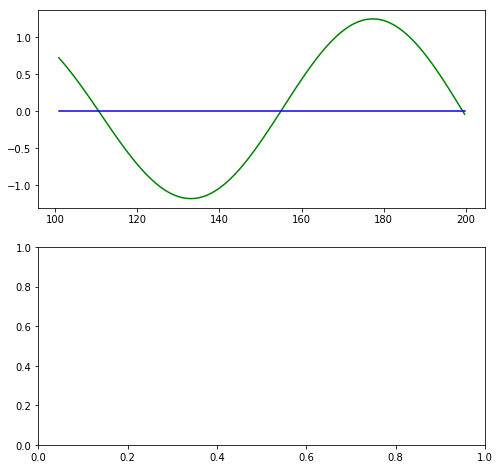

In [6]:
x_trajectory, y_trajectory = run_P(robot, 0.1)
# n = len(x_trajectory)
# for x,y in zip(x_trajectory, y_trajectory):
#     print(x, y)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
ax1.plot(x_trajectory, y_trajectory, 'g', label='P controller')
ax1.plot(x_trajectory, np.zeros(len(x_trajectory)), 'b', label='reference')

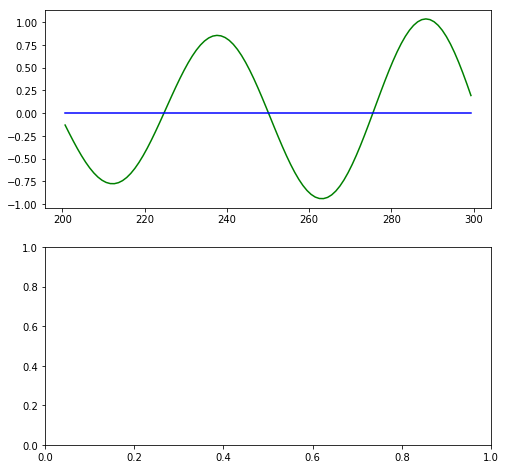

In [7]:
# if we adjust tau to 0.3, which the car ocilliate faster
x_trajectory, y_trajectory = run_P(robot, 0.3)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
ax1.plot(x_trajectory, y_trajectory, 'g', label='P controller')
ax1.plot(x_trajectory, np.zeros(len(x_trajectory)), 'b', label='reference')

In [8]:
# the PD controller
### my try
# def run_PD(robot, tau_p, tau_d, n=100, speed=1.0):
#     x_trajectory = []
#     y_trajectory = []
#     # TODO: your code here
#     cte_previous = 0
#     for i in range(n):
#         steer = - tau_p * robot.y - tau_d * (robot.y - cte_previous)
#         cte_previous = robot.y
#         robot.move(steer, speed)
#         x_trajectory.append(robot.x)
#         y_trajectory.append(robot.y)
#     return x_trajectory, y_trajectory

### the teacher's code, from the shape, it looks like the same. 
def run_PD(robot, tau_p, tau_d, n=100, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    prev_cte = robot.y   # this value is given to the first value, and I think give it zero also work, 
    for i in range(n):
        cte = robot.y
        diff_cte = cte - prev_cte
        prev_cte = cte
        steer = -tau_p * cte - tau_d * diff_cte
        robot.move(steer, speed)
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
    return x_trajectory, y_trajectory

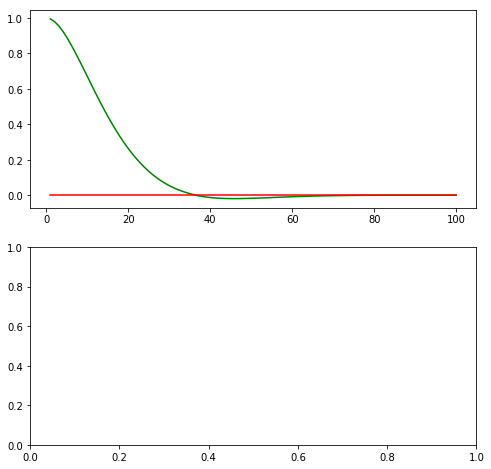

In [11]:
robot = Robot()
robot.set(0, 1, 0)    
x_trajectory, y_trajectory = run_PD(robot, 0.2, 3.0)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
ax1.plot(x_trajectory, y_trajectory, 'g', label='PD controller')
ax1.plot(x_trajectory, np.zeros(len(x_trajectory)), 'r', label='reference')

## systematic bias

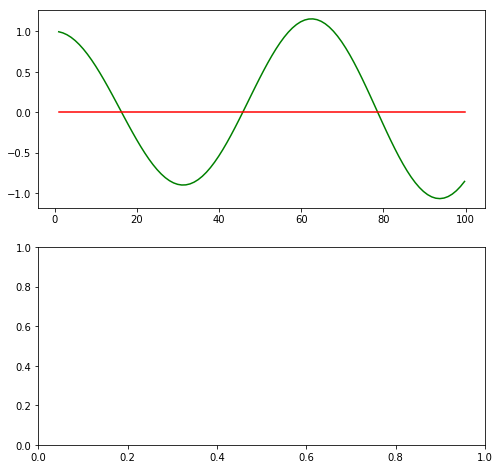

In [12]:
## let's set the drift
robot = Robot()
robot.set(0, 1, 0)   
robot.set_steering_drift(1.0/180.8*np.pi)
## let the tau_d = 0, the lecture said it the systematic bias causes "the bigger cte",
## while from the graph's shape, it's hard to see where are the bigger from? 
## 
x_trajectory, y_trajectory = run_PD(robot, 0.2, 0)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
ax1.plot(x_trajectory, y_trajectory, 'g', label='PD controller')
ax1.plot(x_trajectory, np.zeros(len(x_trajectory)), 'r', label='reference')

## PID Controller

### it interesting, the below two definitions get very different graph shape, 
analyse why such?

In [13]:
# -----------
# User Instructions
#
# Implement a P controller by running 100 iterations
# of robot motion. The steering angle should be set
# by the parameter tau so that:
#
# steering = -tau_p * CTE - tau_d * diff_CTE - tau_i * int_CTE
#
# where the integrated crosstrack error (int_CTE) is
# the sum of all the previous crosstrack errors.
# This term works to cancel out steering drift.
#
# Only modify code at the bottom! Look for the TODO.
# ------------
# def run_PID(robot, tau_p, tau_d, tau_i, n=100, speed=1.0):
#     x_trajectory = []
#     y_trajectory = []
#     # TODO: your code here
#     cte_prev = robot.y
# #     cte_inte = robot.y
#     cte_inte = 0
#     for i in range(n):
#         steer = -tau_p * robot.y - tau_d * (robot.y - cte_prev) - tau_i * cte_inte
#         robot.move(steer, speed)
#         cte_prev = robot.y
#         cte_inte += robot.y
#         x_trajectory.append(robot.x)
#         y_trajectory.append(robot.y)
#     return x_trajectory, y_trajectory

def run_PID(robot, tau_p, tau_d, tau_i, n=100, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    prev_cte = robot.y
    int_cte = 0
    for i in range(n):
        cte = robot.y
        diff_cte = cte - prev_cte
        prev_cte = cte
        int_cte += cte
        steer = -tau_p * cte - tau_d * diff_cte - tau_i * int_cte
        robot.move(steer, speed)
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
    return x_trajectory, y_trajectory


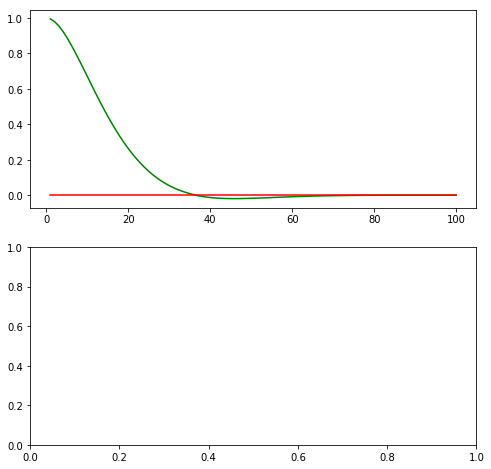

In [14]:
robot = Robot()
robot.set(0, 1, 0)   
# robot.set_steering_drift(1.0/180.8*np.pi)
# x_trajectory, y_trajectory = run_PID(robot, 0.2, 3.0, 0.004)
x_trajectory, y_trajectory = run_PID(robot, 0.2, 3.0, 0)
# n = len(x_trajectory)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))
ax1.plot(x_trajectory, y_trajectory, 'g', label='PID controller')
ax1.plot(x_trajectory, np.zeros(len(x_trajectory)), 'r', label='reference')

## twiddle

In [15]:
def make_robot():
    """
    Resets the robot back to the initial position and drift.
    You'll want to call this after you call `run`.
    """
    robot = Robot()
    robot.set(0, 1, 0)
    robot.set_steering_drift(10 / 180 * np.pi)
    return robot

In [24]:
# NOTE: We use params instead of tau_p, tau_d, tau_i
def run(robot, params, n=100, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    err = 0
    # TODO: your code here
    prev_cte = robot.y
    int_cte = 0
    for i in range(2 * n):
        cte = robot.y
        diff_cte = cte - prev_cte
        int_cte += cte
        prev_cte = cte
        steer = -params[0] * cte - params[1] * diff_cte - params[2] * int_cte
        robot.move(steer, speed)
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
        if i >= n:
            err += cte ** 2
    return x_trajectory, y_trajectory, err / n

In [21]:
# ----------------
# User Instructions
#
# Implement twiddle as shown in the previous two videos.
# Your accumulated error should be very small!
#
# You don't have to use the exact values as shown in the video
# play around with different values! This quiz isn't graded just see
# how low of an error you can get.
#
# Try to get your error below 1.0e-10 with as few iterations
# as possible (too many iterations will cause a timeout).
#
# No cheating!
# ------------
# Make this tolerance bigger if you are timing out!
# def twiddle(tol=0.2): 
#     # Don't forget to call `make_robot` before you call `run`!
#     p = [0, 0, 0]
#     dp = [1, 1, 1]
#     robot = make_robot()
#     x_trajectory, y_trajectory, best_err = run(robot, p)
#     # TODO: twiddle loop here
#     while sum(dp) > tol:
#         for i in range(len(p)):
#             p[i] += dp[i]
#         x_trajectory, y_trajectory, err = run(robot, p)
        
#         if err < best_err:
#             best_err = err;
#             dp = [1.1 * x for x in dp]
#         else:
#             for i in range(len(p)):
#                 p[i] -= 2*dp[i]
        
#         else:
#             pass
            
#     return p, best_err

In [25]:
# the teacher's work
def twiddle(tol=0.2): 
    p = [0, 0, 0]
    dp = [1, 1, 1]
    robot = make_robot()
    x_trajectory, y_trajectory, best_err = run(robot, p)

    it = 0
    while sum(dp) > tol:
        print("Iteration {}, best error = {}".format(it, best_err))
        for i in range(len(p)):
            p[i] += dp[i]
            robot = make_robot()
            x_trajectory, y_trajectory, err = run(robot, p)

            if err < best_err:
                best_err = err
                dp[i] *= 1.1
            else:
                p[i] -= 2 * dp[i]
                robot = make_robot()
                x_trajectory, y_trajectory, err = run(robot, p)

                if err < best_err:
                    best_err = err
                    dp[i] *= 1.1
                else:
                    p[i] += dp[i]
                    dp[i] *= 0.9
        it += 1
    return p

Iteration 0, best error = 8315.955485215645
Iteration 1, best error = 0.04349708072568837
Iteration 2, best error = 0.03065437362443958
Iteration 3, best error = 0.007677320020069422
Iteration 4, best error = 0.003220167427116263
Iteration 5, best error = 0.0016645945527960432
Iteration 6, best error = 0.0009761080831886472
Iteration 7, best error = 0.0006163432367765914
Iteration 8, best error = 0.00041102750373812327
Iteration 9, best error = 0.0001987737411478128
Iteration 10, best error = 1.1769110322775785e-06
Iteration 11, best error = 7.05088435264859e-07
Iteration 12, best error = 1.379736671356056e-12
Iteration 13, best error = 1.379736671356056e-12
Iteration 14, best error = 1.379736671356056e-12
Iteration 15, best error = 1.0756081254381531e-12
Iteration 16, best error = 1.0756081254381531e-12
Iteration 17, best error = 1.0756081254381531e-12
Iteration 18, best error = 8.128577728545796e-13
Iteration 19, best error = 8.128577728545796e-13
Iteration 20, best error = 8.1285777

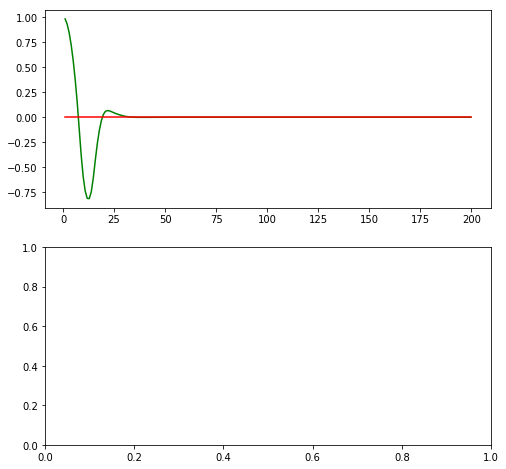

In [28]:
# params, err = twiddle()
params = twiddle()
# print("Final twiddle error = {}".format(err))
robot = make_robot()
x_trajectory, y_trajectory, err = run(robot, params)
print("Final twiddle error = {}".format(err))
n = len(x_trajectory)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
ax1.plot(x_trajectory, y_trajectory, 'g', label='Twiddle PID controller')
ax1.plot(x_trajectory, np.zeros(n), 'r', label='reference')